In [1]:
!pip install pymc

In [2]:
import pymc

In [3]:
!pip install arviz

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import arviz as az
import pymc as pm


In [6]:
!git clone https://github.com/Komondi/Modelling-fire-frequency-in-Kenya.git

Cloning into 'Modelling-fire-frequency-in-Kenya'...
remote: Enumerating objects: 9326, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9326 (delta 20), reused 20 (delta 20), pack-reused 9303 (from 1)
Receiving objects: 100% (9326/9326), 96.03 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (194/194), done.
Updating files: 100% (16965/16965), done.


In [7]:
# --- 1. Read data ------------------------------------------------------
fire_clim = pd.read_csv('/content/Modelling-fire-frequency-in-Kenya/fire_data_2000-18.csv')

# --- 2. Summary statistics ---------------------------------------------
cols = ['count', 'mean_max_temp', 'mean_min_temp', 'mean_rainfall']
fire_clim2 = fire_clim[cols]
summary_stats = fire_clim2.describe()
print(summary_stats)

             count  mean_max_temp  mean_min_temp  mean_rainfall
count   106.000000     106.000000     106.000000     106.000000
mean    302.905660      28.668491      17.801828      81.417938
std     314.978897       2.103193       1.957741      50.119544
min      13.000000      22.222404      12.287597       8.430473
25%      70.000000      27.608073      16.828516      45.447613
50%     175.500000      28.677541      17.981352      68.151520
75%     385.750000      29.982897      18.996341     112.537426
max    1402.000000      32.818002      22.181305     241.947442


In [8]:
# --- 3. Create time series object --------------------------------------
fire_clim['Time'] = pd.to_datetime(
    fire_clim[['year', 'month']].assign(day=1)
)
count_ts = fire_clim.copy()

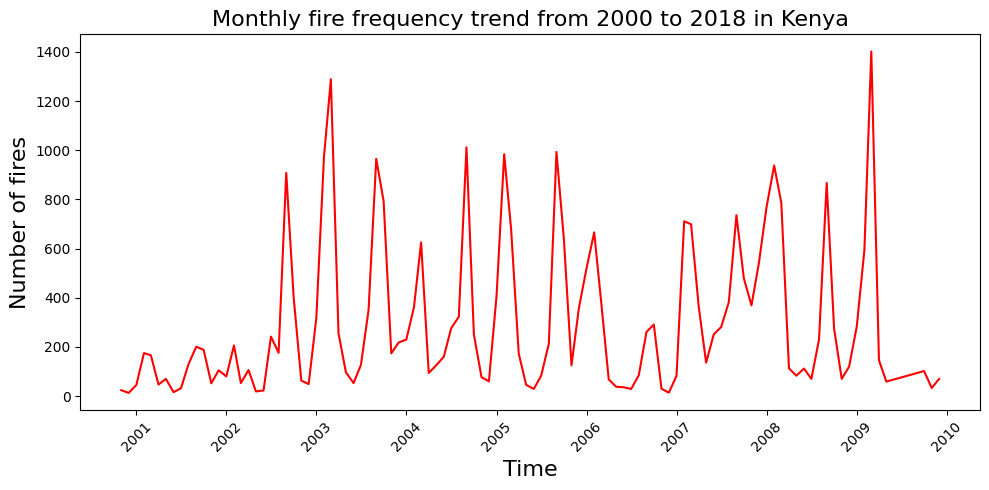

In [9]:
# --- 4. Plot monthly fire frequency -----------------------------------
plt.figure(figsize=(10, 5))
plt.plot(count_ts['Time'], count_ts['count'], color='red')
plt.title('Monthly fire frequency trend from 2000 to 2018 in Kenya', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of fires', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


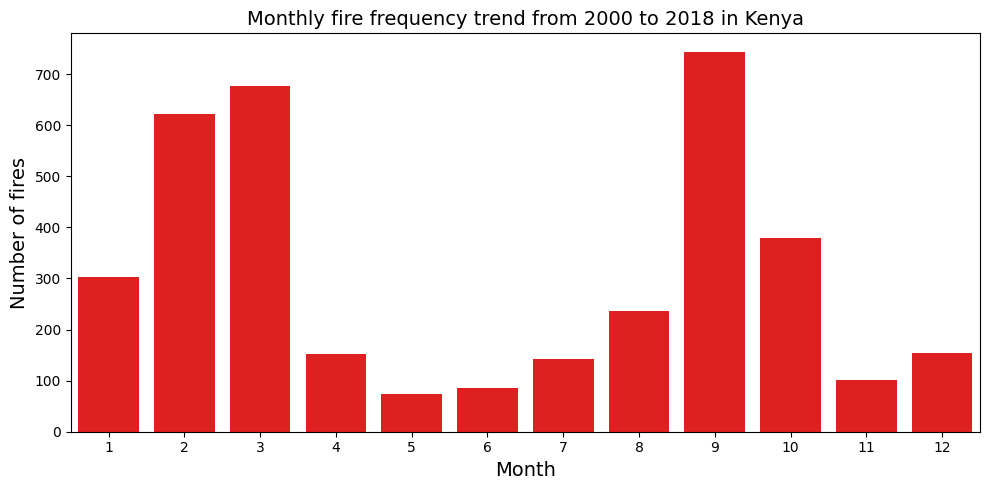

In [10]:
# --- 5. Bar plot of mean count by month -------------------------------
mean_by_month = count_ts.groupby('month')['count'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=mean_by_month, x='month', y='count', color='red')
plt.title('Monthly fire frequency trend from 2000 to 2018 in Kenya', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of fires', fontsize=14)
plt.tight_layout()
plt.show()

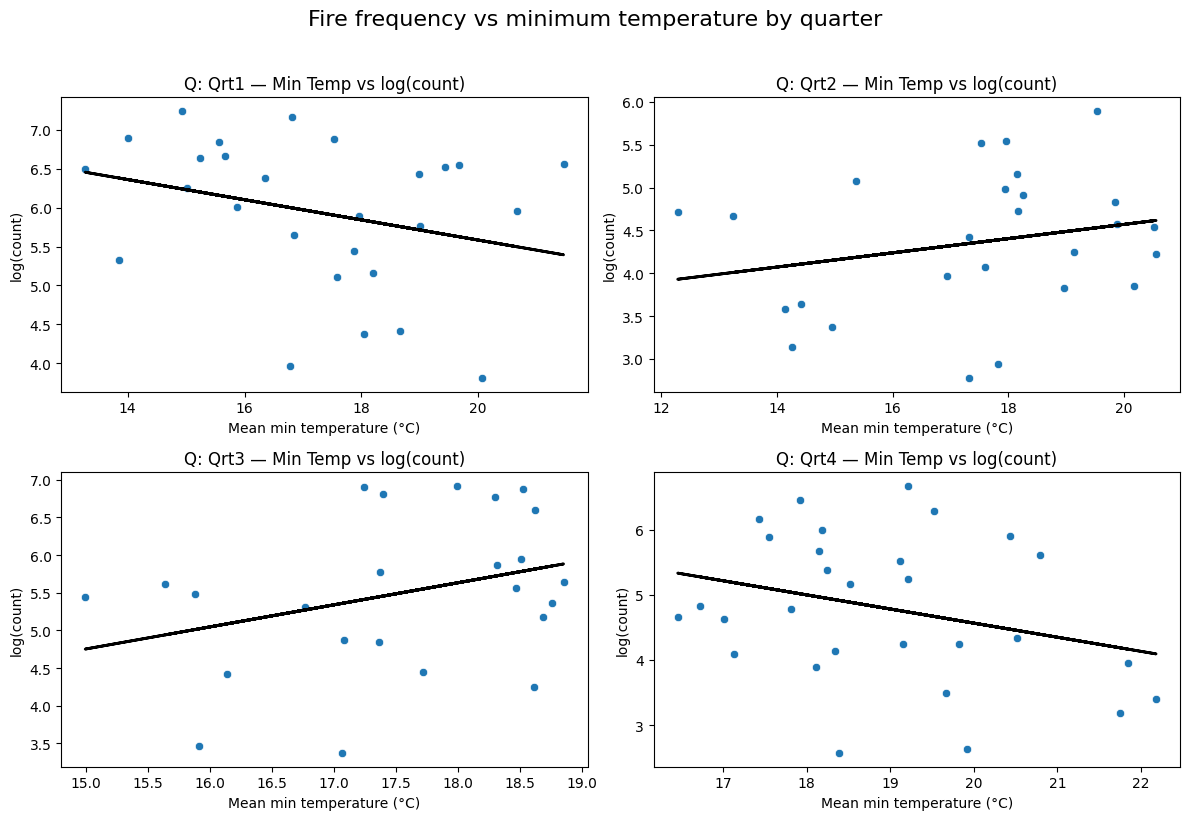

In [11]:
# --- 6. Correlation plots by quarter ----------------------------------
def quarter(m):
    if m < 4:
        return 'Qrt1'
    elif m < 7:
        return 'Qrt2'
    elif m < 10:
        return 'Qrt3'
    else:
        return 'Qrt4'

count_ts['quarter'] = count_ts['month'].apply(quarter)

# Min temp vs log(count)
plt.figure(figsize=(12, 8))
for i, q in enumerate(sorted(count_ts['quarter'].unique())):
    ax = plt.subplot(2, 2, i + 1)
    subset = count_ts[count_ts['quarter'] == q]
    x = subset['mean_min_temp']
    y = np.log(subset['count'])
    sns.scatterplot(x=x, y=y, ax=ax)
    slope, intercept, _, _, _ = stats.linregress(x, y)
    ax.plot(x, intercept + slope * x, lw=2, color='black')
    ax.set_title(f"Q: {q} — Min Temp vs log(count)")
    ax.set_xlabel("Mean min temperature (°C)")
    ax.set_ylabel("log(count)")
plt.suptitle("Fire frequency vs minimum temperature by quarter", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

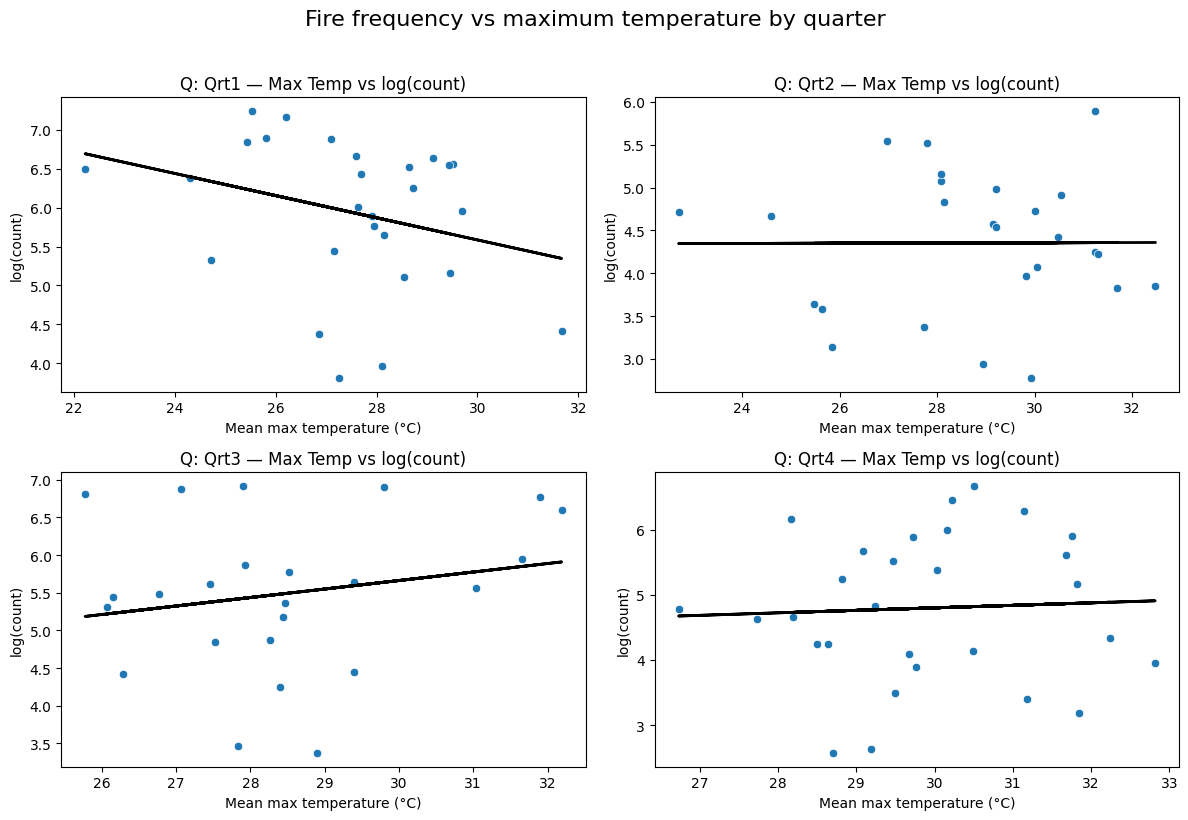

In [12]:
# Max temp vs log(count)
plt.figure(figsize=(12, 8))
for i, q in enumerate(sorted(count_ts['quarter'].unique())):
    ax = plt.subplot(2, 2, i + 1)
    subset = count_ts[count_ts['quarter'] == q]
    x = subset['mean_max_temp']
    y = np.log(subset['count'])
    sns.scatterplot(x=x, y=y, ax=ax)
    slope, intercept, _, _, _ = stats.linregress(x, y)
    ax.plot(x, intercept + slope * x, lw=2, color='black')
    ax.set_title(f"Q: {q} — Max Temp vs log(count)")
    ax.set_xlabel("Mean max temperature (°C)")
    ax.set_ylabel("log(count)")
plt.suptitle("Fire frequency vs maximum temperature by quarter", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


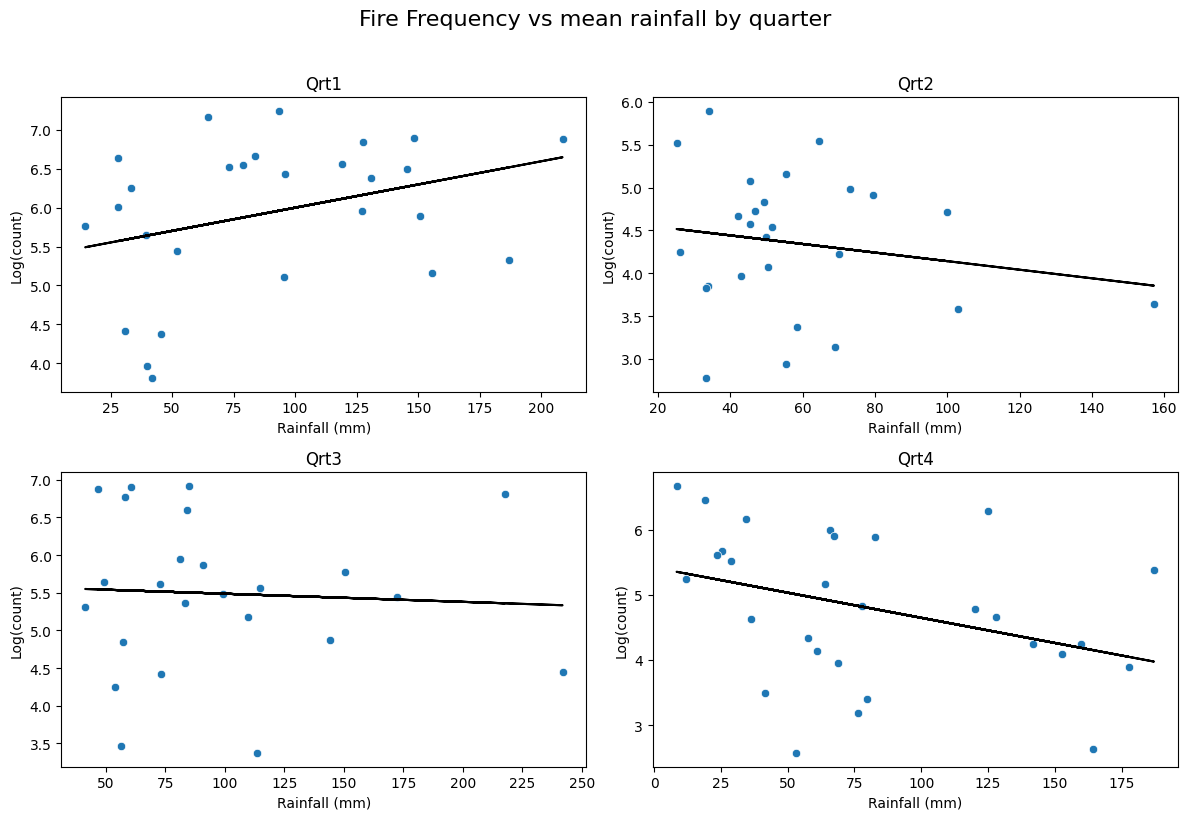

In [13]:
# Rainfall vs log(count)
plt.figure(figsize=(12, 8))
for i, q in enumerate(sorted(count_ts['quarter'].unique())):
    ax = plt.subplot(2, 2, i + 1)
    subset = count_ts[count_ts['quarter'] == q]
    x = subset['mean_rainfall']
    y = np.log(subset['count'])
    sns.scatterplot(x=x, y=y, ax=ax)
    slope, intercept, *_ = stats.linregress(x, y)
    ax.plot(x, intercept + slope * x, color='black')
    ax.set_title(q)
    ax.set_xlabel('Rainfall (mm)')
    ax.set_ylabel('Log(count)')
plt.suptitle("Fire Frequency vs mean rainfall by quarter", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

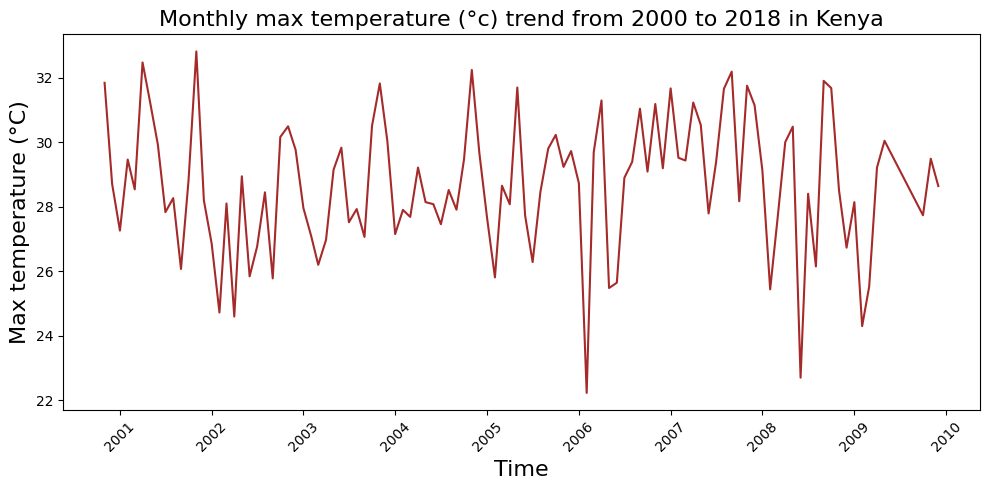

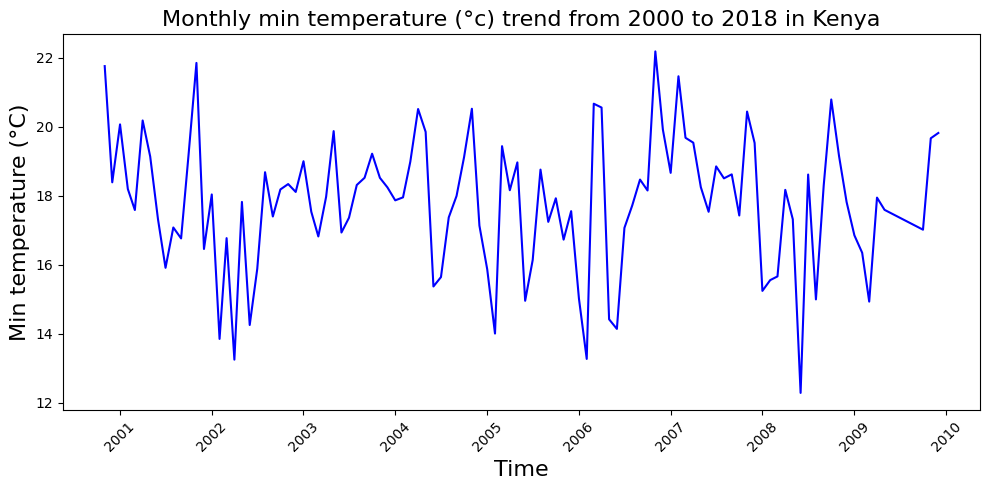

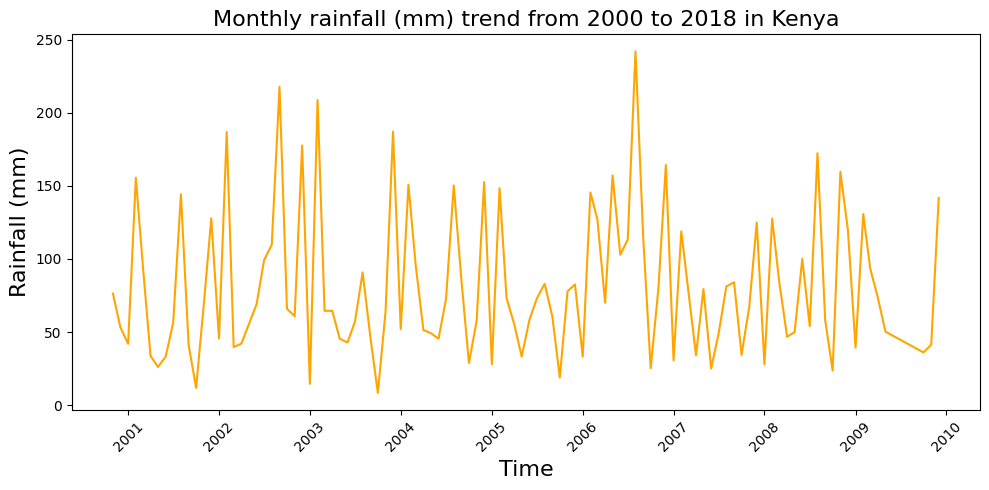

In [14]:
# --- 7. Time series of max, min temperature and rainfall ------------
for var, color, ylabel in [
    ('mean_max_temp', 'brown', 'Max temperature (°C)'),
    ('mean_min_temp', 'blue', 'Min temperature (°C)'),
    ('mean_rainfall', 'orange', 'Rainfall (mm)')
]:
    plt.figure(figsize=(10, 5))
    plt.plot(count_ts['Time'], count_ts[var], color=color)
    plt.title(f'Monthly {ylabel.lower()} trend from 2000 to 2018 in Kenya', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

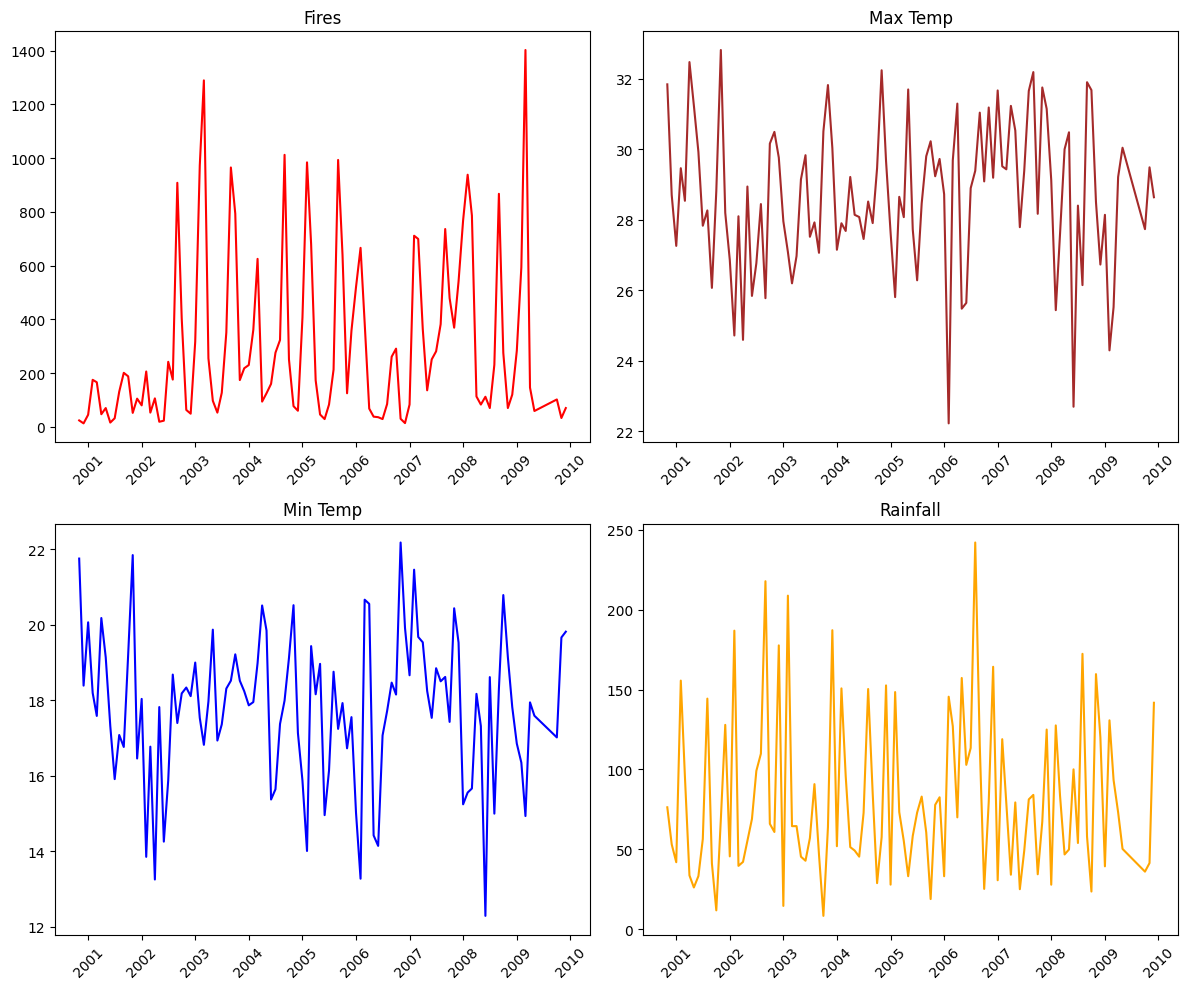

In [15]:
# --- 8. Combined subplots --------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
vars_colors = [
    ('count', 'red', 'Fires'),
    ('mean_max_temp', 'brown', 'Max Temp'),
    ('mean_min_temp', 'blue', 'Min Temp'),
    ('mean_rainfall', 'orange', 'Rainfall')
]
for ax, (var, col, label) in zip(axes.flatten(), vars_colors):
    ax.plot(count_ts['Time'], count_ts[var], color=col)
    ax.set_title(label)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

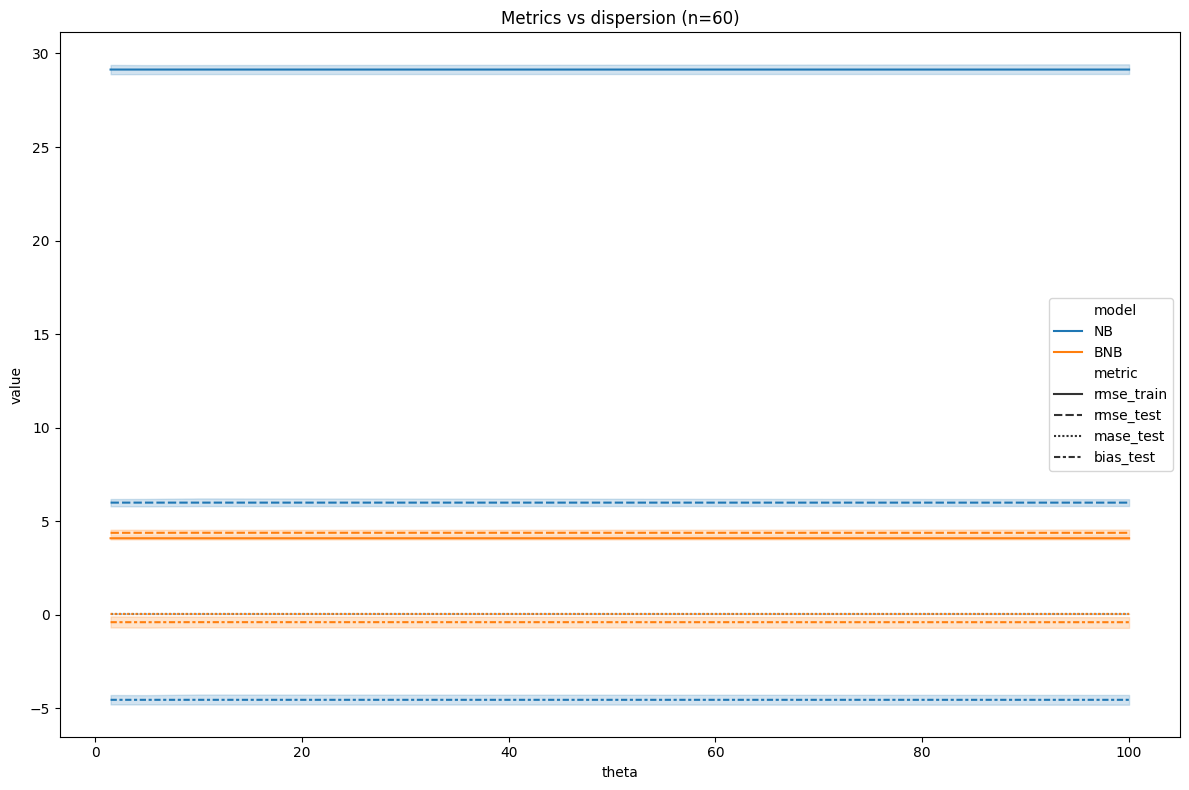

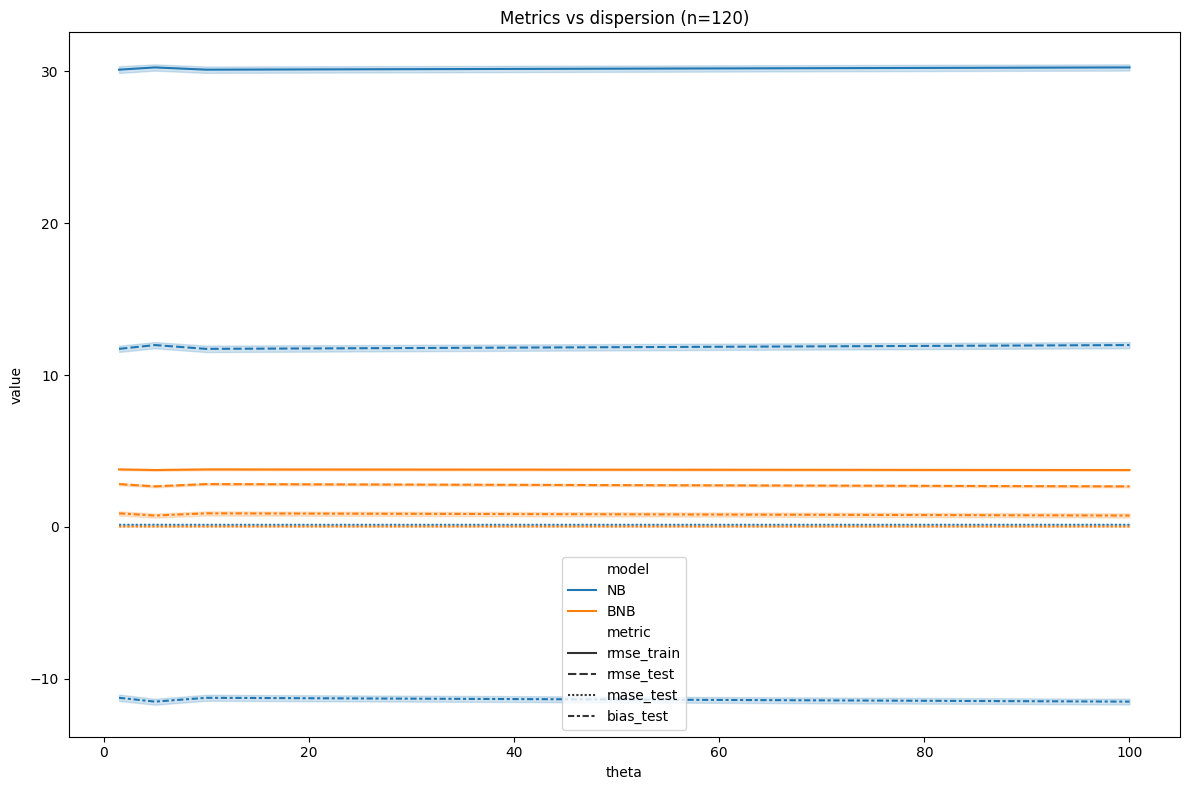

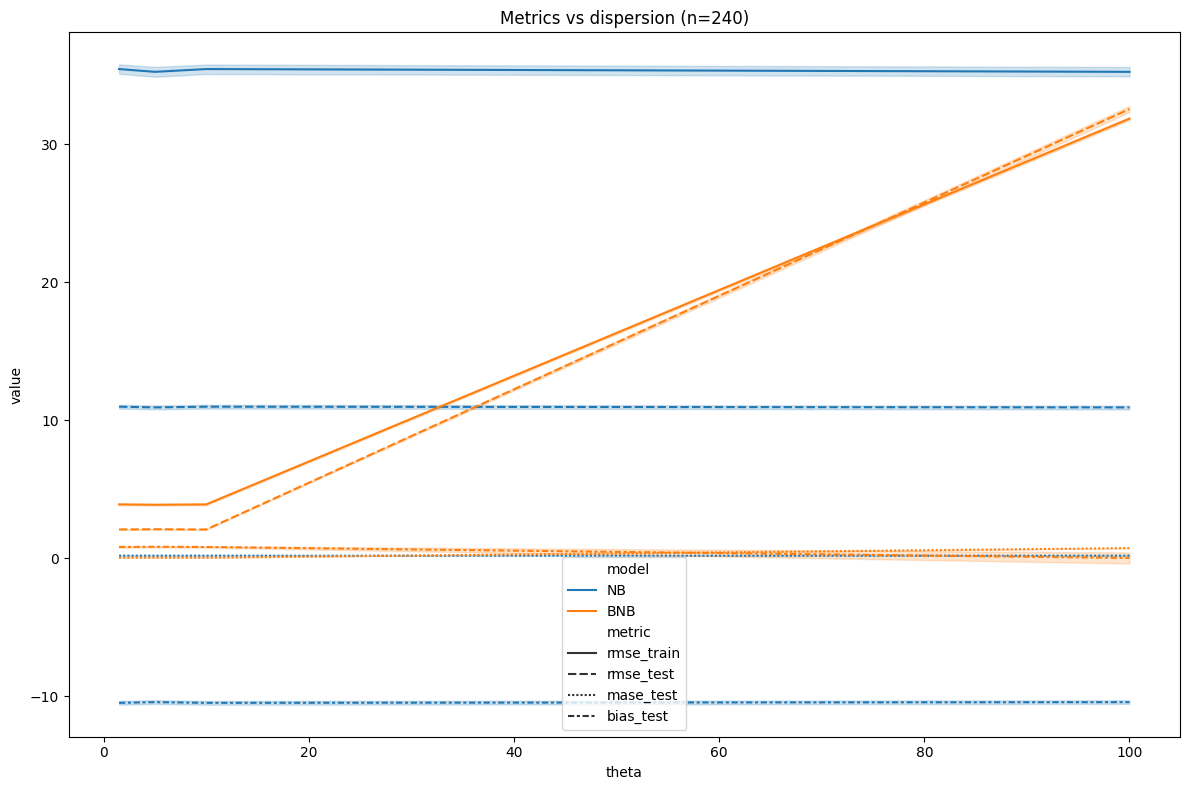

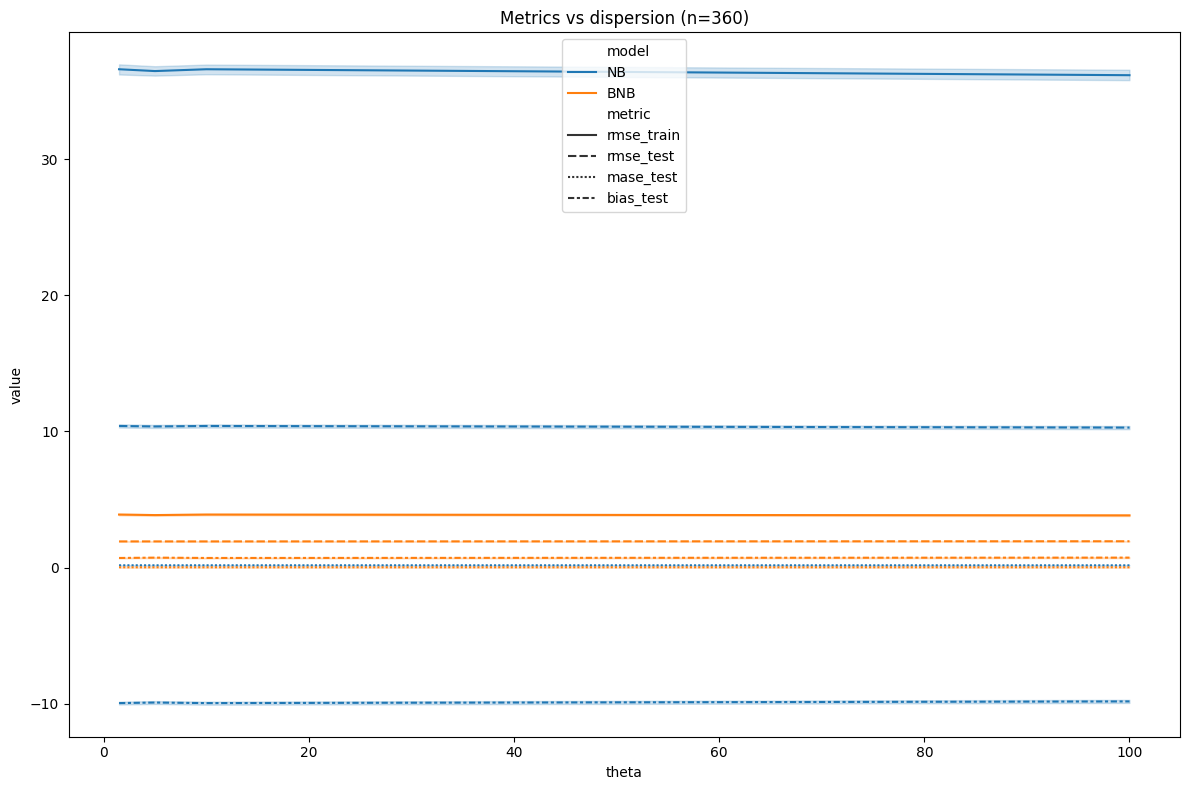

In [16]:
# --- 9. Read and combine model results -------------------------------
# Python lines 103-141 == R lines 95-160
# Note: theta values (1.5, 5, 10, 100) correspond to dispersion parameter θ used
# in the filenames of your R code (e.g., five_year_1.5_metrics.csv represents θ=1.5).


number_map = {
    5: 'five',
    10: 'ten',
    20: 'twenty',
    30: 'thirty'
}





metrics = []
for horizon, theta in [
    (5, 1.5), (10, 1.5), (20, 1.5), (30, 1.5),
    (5, 5), (10, 5), (20, 5), (30, 5),
    (5, 10), (10, 10), (20, 10), (30, 10),
    (5, 100), (10, 100), (20, 100), (30, 100)
]:
    # theta values are derived from your R file suffixes and represent the dispersion parameter
    for suffix in ['', 'b']:
        horizon_word = number_map[horizon]
        fname = f'./Modelling-fire-frequency-in-Kenya/model_results/{horizon_word}_year_{theta}{suffix}_metrics.csv'
        df = pd.read_csv(fname)
        df['model'] = 'BNB' if suffix == 'b' else 'NB'
        df['n'] = 12 * horizon  # n corresponds to sample size in months
        df['theta'] = theta
        metrics.append(df)
all_metrics = pd.concat(metrics, ignore_index=True)
long = all_metrics.melt(
    id_vars=['n', 'theta', 'model'],
    value_vars=['rmse_train', 'rmse_test', 'mase_test', 'bias_test'],
    var_name='metric', value_name='value'
)

# Plotting for each horizon
for horizon in [5, 10, 20, 30]:
    n_value = 12 * horizon
    subset = long[long['n'] == n_value]
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=subset, x='theta', y='value', hue='model', style='metric')
    plt.title(f'Metrics vs dispersion (n={n_value})')
    plt.tight_layout()
    plt.show()

In [17]:
# --- 10. Export combined simulation results --------------------------
final_sim = long.groupby(['metric', 'model', 'n', 'theta'])['value'].mean().reset_index()
final_sim.to_csv('paper_sim_results_py.csv', index=False)

In [38]:
# --- 11. Functions for NB and Bayesian NB ----------------------------
def negbinner2(df, prop=0.8, seed=456):
    np.random.seed(seed)
    n = len(df)
    idx = int(prop * n)
    train, test = df.iloc[:idx], df.iloc[idx:]
    train['season_sin'] = np.sin((2 * train['tyme'] * np.pi / 12)  + np.random.normal(scale=0.1))
    train['season_cos'] = np.cos((2 * train['tyme'] * np.pi / 12)  + np.random.normal(scale=0.1))
    X_train = sm.add_constant(train[['mean_max_temp', 'mean_rainfall', 'season_sin', 'season_cos']])
    y_train = train['count']
    model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()
    X_test = sm.add_constant(test[['mean_max_temp', 'mean_rainfall']].assign(
        season_sin=np.sin((2 * test['tyme'] * np.pi) /12 ),
        season_cos=np.cos((2 * test['tyme'] * np.pi) /12 )
    ))
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, np.round(pred_train)))
    rmse_test = np.sqrt(mean_squared_error(test['count'], np.round(pred_test)))
    def mase(actual, pred):
        return np.mean(np.abs(actual - pred)) / np.mean(np.abs(np.diff(train['count'])))
    test_mase = mase(test['count'], np.round(pred_test))
    test_bias = 100 * np.sum(test['count'] - np.round(pred_test)) / np.sum(test['count'])
    return pd.DataFrame([{
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mase_test': test_mase,
        'bias_test': test_bias,
        'n': n,
        'prop': prop
    }])

In [39]:
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import arviz as az

def stanbinner3(df, prop=0.8, seed=456):
    np.random.seed(seed)
    data = df.copy()
    n = len(data['count'])
    data['tyme'] = np.arange(1, n+1)
    noise_sin = np.random.normal(loc=0, scale=0.1)
    noise_cos = np.random.normal(loc=0, scale=0.1)
    data['sin_term'] = np.sin((2 * data['tyme'] * np.pi / 12) + noise_sin)
    data['cos_term'] = np.cos((2 * data['tyme'] * np.pi /12) + noise_cos)
    train_idx = int(round(prop * n))
    train = data.iloc[:train_idx].reset_index(drop=True)
    test  = data.iloc[train_idx:].reset_index(drop=True)

    # PyMC4 NB model
    with pm.Model() as pymc_nb:
        # Define observed data as PyTensor shared variables
        obs_id = pm.MutableData("obs_id", np.arange(len(train)), dims="data_dim") # Add obs_id for dynamic sizing
        mean_max_temp_shared = pm.Data("mean_max_temp", train["mean_max_temp"].values, dims="data_dim")
        mean_rainfall_shared = pm.Data("mean_rainfall", train["mean_rainfall"].values, dims="data_dim")
        sin_term_shared = pm.Data("sin_term", train["sin_term"].values, dims="data_dim")
        cos_term_shared = pm.Data("cos_term", train["cos_term"].values, dims="data_dim")


        intercept = pm.Normal("Intercept", mu=0, sigma=5)
        beta_max     = pm.Normal("beta_mean_max_temp", mu=0, sigma=2.5)
        beta_rain    = pm.Normal("beta_mean_rainfall", mu=0, sigma=2.5)
        beta_sin     = pm.Normal("beta_sin_term", mu=0, sigma=2.5)
        beta_cos     = pm.Normal("beta_cos_term", mu=0, sigma=2.5)
        α         = pm.Exponential("alpha", lam=1)

        μ = tt.exp(
            intercept +
            beta_max  * mean_max_temp_shared +
            beta_rain * mean_rainfall_shared +
            beta_sin  * sin_term_shared +
            beta_cos  * cos_term_shared
        )

        y_obs = pm.NegativeBinomial("y_obs",
                                    mu=μ,
                                    alpha=α,
                                    observed=train["count"].values,
                                    dims="data_dim") # Use dims for dynamic sizing

        trace = pm.sample(draws=2000, tune=1000, chains=4,
                          random_seed=seed, return_inferencedata=True)

    # Posterior predictive & point estimates
    with pymc_nb:
        # Set the data to train data for train predictions
        pm.set_data(
            {
                "mean_max_temp": train["mean_max_temp"].values,
                "mean_rainfall": train["mean_rainfall"].values,
                "sin_term": train["sin_term"].values,
                "cos_term": train["cos_term"].values,
                 "obs_id": np.arange(len(train)) # Update obs_id with train data size
            }
        )
        ppc_train = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)

        # Set the data to test data for test predictions
        pm.set_data(
            {
                "mean_max_temp": test["mean_max_temp"].values,
                "mean_rainfall": test["mean_rainfall"].values,
                "sin_term": test["sin_term"].values,
                "cos_term": test["cos_term"].values,
                 "obs_id": np.arange(len(test)) # Update obs_id with test data size
            }
        )
        ppc_test  = pm.sample_posterior_predictive(trace, var_names=["y_obs"], predictions=True)

    pred_train2 = np.round(ppc_train.predictions["y_obs"].mean(dim=["chain","draw"]).values)
    pred_test2  = np.round(ppc_test.predictions["y_obs"].mean(dim=["chain","draw"]).values)

    rmse_train = np.sqrt(mean_squared_error(train['count'], pred_train2))
    rmse_test  = np.sqrt(mean_squared_error(test['count'], pred_test2))
    errors_test = np.abs(test['count'] - pred_test2)
    naive_errors = np.abs(np.diff(test['count']))
    mase_test = errors_test.mean() / naive_errors.mean()
    bias_test = 100 * (pred_test2 - test['count']).sum() / test['count'].sum()

    return pd.DataFrame([{  'rmse_train': rmse_train,
                             'rmse_test':  rmse_test,
                             'mase_test':  mase_test,
                             'bias_test':  bias_test,
                             'n':          n,
                             'prop':       prop }])

In [40]:
series_data = pd.read_csv('/content/Modelling-fire-frequency-in-Kenya/fire_data_2000-18.csv')    # read_csv("fire_data_2000-18.csv")

# add quarter and tyme (equivalent to the R mutate calls)
def quarter(m):
    if m < 4:
        return 1
    elif m < 7:
        return 2
    elif m < 10:
        return 3
    else:
        return 4

series_data2 = series_data.copy()
series_data2['qrt']  = series_data2['month'].apply(quarter)          # mutate(qrt = ...)
series_data2['tyme'] = np.arange(1, len(series_data2) + 1)

In [41]:
# ---- Set seed ----
np.random.seed(76568)                                                # set.seed(76568)

# ---- Standard NB (assumes you have a negbinner2() Python function) ----
nb_result80 = negbinner2(series_data2, prop=0.8)                     # negbinner2(..., prop = 0.8)
nb_result90 = negbinner2(series_data2, prop=0.9)                     # negbinner2(..., prop = 0.9)
nb_result95 = negbinner2(series_data2, prop=0.95)                    # negbinner2(..., prop = 0.95)

# ---- Bayesian NBT (your Bambi‐based stanbinner3 from before) ----
bnbt_result80 = stanbinner3(series_data2, prop=0.8)                 # stanbinner3(..., prop = 0.8)
bnbt_result90 = stanbinner3(series_data2, prop=0.9)                 # stanbinner3(..., prop = 0.9)
bnbt_result95 = stanbinner3(series_data2, prop=0.95)

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

Output()

ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Output()

In [42]:
# ---- Combine and round results just like the R rbind + mutate_if(…, round, 2) ----
combined_results = pd.concat([
    nb_result80.assign(method="NB80"),
    bnbt_result80.assign(method="BNBT80")
], ignore_index=True)

In [43]:
# round all numeric columns to 2 decimals
for col in combined_results.select_dtypes(include="number").columns:
    combined_results[col] = combined_results[col].round(2)

print(combined_results)

   rmse_train  rmse_test  mase_test  bias_test    n  prop  method
0      285.62     359.51       1.20      18.21  106   0.8    NB80
1      287.96     366.66       0.93     -14.41  106   0.8  BNBT80


In [44]:
# ---- Fit the model on the whole dataset to get beta estimates ----
x = series_data2.copy()
np.random.seed(456)                                                 # set.seed(456)

# re-create tyme & noise terms as in stanbinner3
n = len(x)
x['tyme'] = np.arange(1, n+1)
noise_sin = np.random.normal(0, 0.1)
noise_cos = np.random.normal(0, 0.1)
x['sin_term'] = np.sin((2 * x['tyme'] * np.pi / 12) + noise_sin) # seasonality change 7
x['cos_term'] = np.cos((2 * x['tyme'] * np.pi / 12) + noise_cos) # seasonality change 8


In [48]:
# ---- Fit the model on the whole dataset to get beta estimates ----
# This code is based on the PyMC model in the stanbinner3 function
with pm.Model() as full_model:
    # Define observed data as PyTensor shared variables
    obs_id = pm.MutableData("obs_id", np.arange(len(x)), dims="data_dim") # Add obs_id for dynamic sizing
    mean_max_temp_shared = pm.Data("mean_max_temp", x["mean_max_temp"].values, dims="data_dim")
    mean_rainfall_shared = pm.Data("mean_rainfall", x["mean_rainfall"].values, dims="data_dim")
    sin_term_shared = pm.Data("sin_term", x["sin_term"].values, dims="data_dim")
    cos_term_shared = pm.Data("cos_term", x["cos_term"].values, dims="data_dim")

    intercept = pm.Normal("Intercept", mu=0, sigma=5)
    beta_max     = pm.Normal("beta_mean_max_temp", mu=0, sigma=2.5)
    beta_rain    = pm.Normal("beta_mean_rainfall", mu=0, sigma=2.5)
    beta_sin     = pm.Normal("beta_sin_term", mu=0, sigma=2.5)
    beta_cos     = pm.Normal("beta_cos_term", mu=0, sigma=2.5)
    α         = pm.Exponential("alpha", lam=1)

    μ = tt.exp(
        intercept +
        beta_max  * mean_max_temp_shared +
        beta_rain * mean_rainfall_shared +
        beta_sin  * sin_term_shared +
        beta_cos  * cos_term_shared
    )

    y_obs = pm.NegativeBinomial("y_obs",
                                mu=μ,
                                alpha=α,
                                observed=x["count"].values,
                                dims="data_dim") # Use dims for dynamic sizing

    full_fit = pm.sample(draws=2000, tune=1000, chains=4,
                      random_seed=456, return_inferencedata=True)

Output()

In [50]:
# ---- Extract and tidy the output (broom.mixed::tidy + posterior_interval) ----
# get posterior summaries (mean, sd, etc.)
tidied = az.summary(full_fit, var_names=["Intercept",
                                          "beta_mean_max_temp",
                                          "beta_mean_rainfall",
                                          "beta_sin_term",
                                          "beta_cos_term",
                                          "alpha"],
                    kind="stats")

In [53]:
 # get 95% credible intervals
ci_dataset = az.hdi(full_fit,
            hdi_prob=0.95)[["Intercept",
                            "beta_mean_max_temp",
                            "beta_mean_rainfall",
                            "beta_sin_term",
                            "beta_cos_term",
                            "alpha"]]

# Convert the ci Dataset to a DataFrame
ci_df = ci_dataset.to_dataframe()

# combine summaries & intervals (like cbind in R)
# tidied is already a DataFrame with index as variable names
# ci_df is now a DataFrame with index as variable names and hdi bounds as columns
comb_table = pd.concat([tidied, ci_df], axis=1)

print(comb_table)

                     mean     sd  hdi_3%  hdi_97%  Intercept  \
Intercept           8.122  1.484   5.410   10.966        NaN   
beta_mean_max_temp -0.087  0.050  -0.181    0.005        NaN   
beta_mean_rainfall  0.001  0.002  -0.003    0.005        NaN   
beta_sin_term       0.456  0.156   0.172    0.754        NaN   
beta_cos_term       0.380  0.147   0.105    0.657        NaN   
alpha               1.089  0.134   0.836    1.335        NaN   
lower                 NaN    NaN     NaN      NaN   5.178151   
higher                NaN    NaN     NaN      NaN  10.978403   

                    beta_mean_max_temp  beta_mean_rainfall  beta_sin_term  \
Intercept                          NaN                 NaN            NaN   
beta_mean_max_temp                 NaN                 NaN            NaN   
beta_mean_rainfall                 NaN                 NaN            NaN   
beta_sin_term                      NaN                 NaN            NaN   
beta_cos_term                      NaN

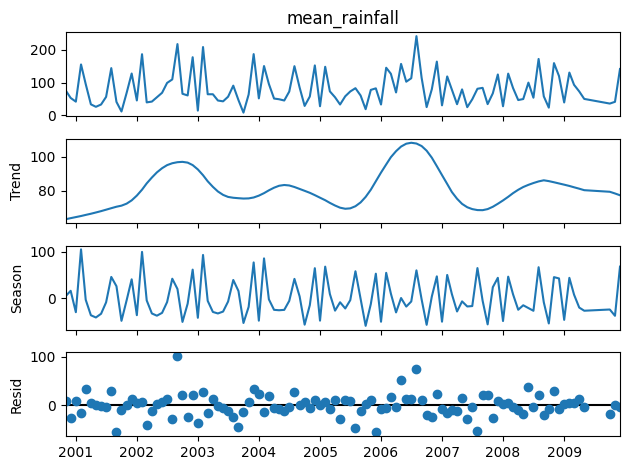

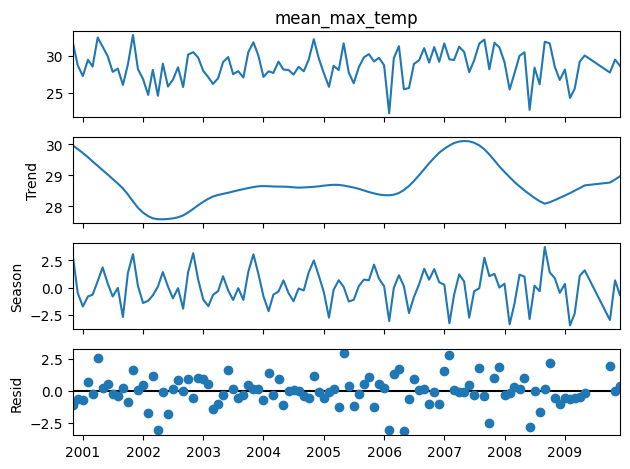

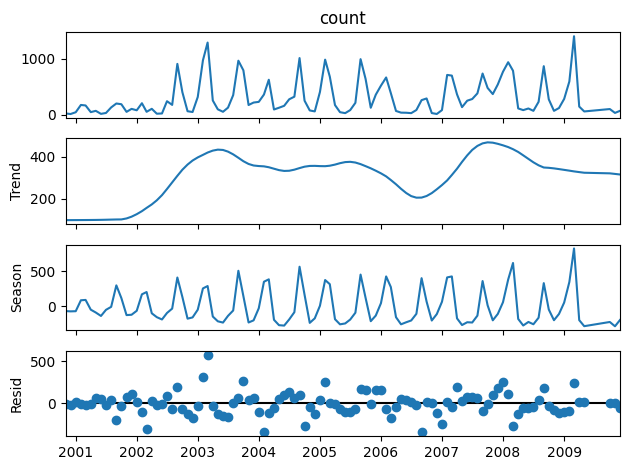

In [54]:
# --- 12. Time series decomposition -----------------------------------
# Python lines 186-202 == R lines 262-290
rain_ts = fire_clim.set_index('Time')['mean_rainfall']
stl_rain = STL(rain_ts, period=12).fit()
stl_rain.plot(); plt.show()

temp_ts = fire_clim.set_index('Time')['mean_max_temp']
stl_temp = STL(temp_ts, period=12).fit()
stl_temp.plot(); plt.show()

fire_ts = fire_clim.set_index('Time')['count']
stl_fire = STL(fire_ts, period=12).fit()
stl_fire.plot(); plt.show()

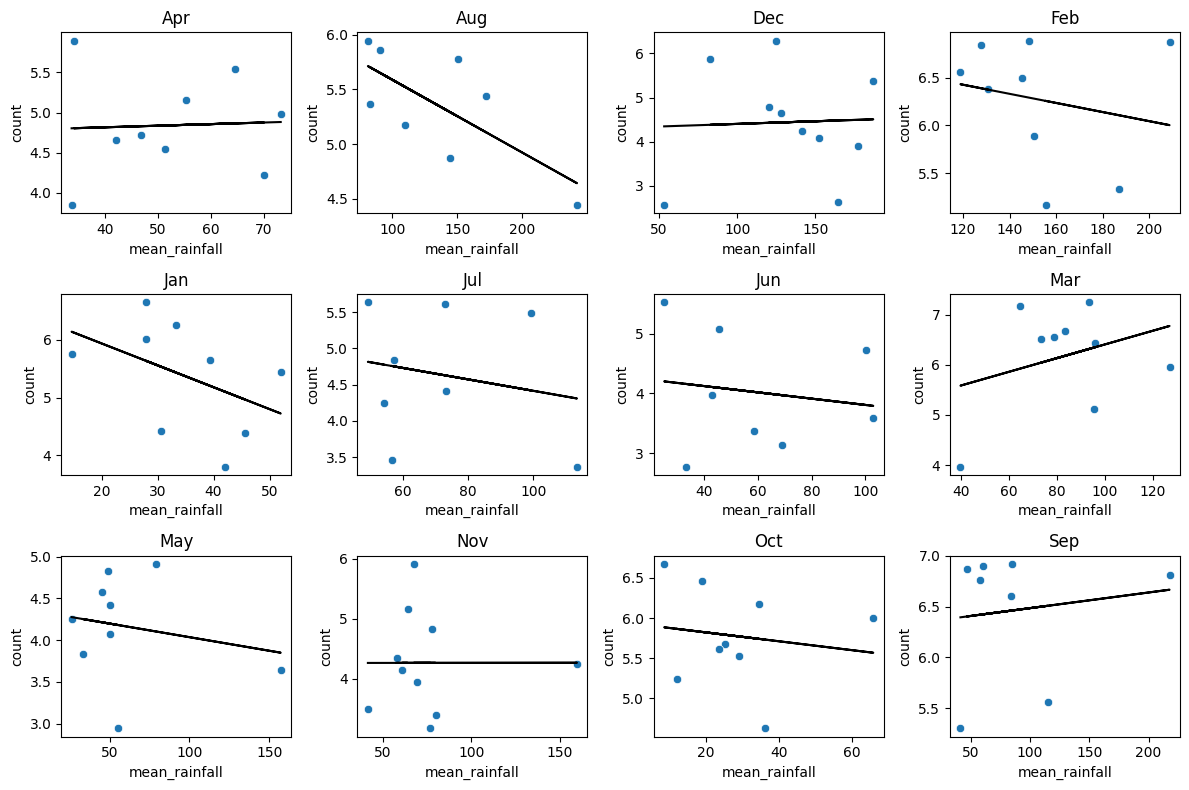

In [55]:
# que: need to implement for max temp as well 1378 to 1405 R code
# ans: will do it below
fire_clim['month2'] = fire_clim['month'].map(dict(enumerate(
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], start=1)))
plt.figure(figsize=(12, 8))
for i, m in enumerate(sorted(fire_clim['month2'].unique())):
    ax = plt.subplot(3, 4, i + 1)
    sub = fire_clim[fire_clim['month2'] == m]
    sns.scatterplot(x='mean_rainfall', y=np.log(sub['count']), data=sub, ax=ax)
    slope, intercept, *_ = stats.linregress(sub['mean_rainfall'], np.log(sub['count']))
    # que: there was x before why not intercept+slope*x now?
    # ans: does not make a difference, both are correct, just differenct ways of doing the same thing
    ax.plot(sub['mean_rainfall'], intercept + slope * sub['mean_rainfall'], color='black')
    ax.set_title(m)
plt.tight_layout()
plt.show()

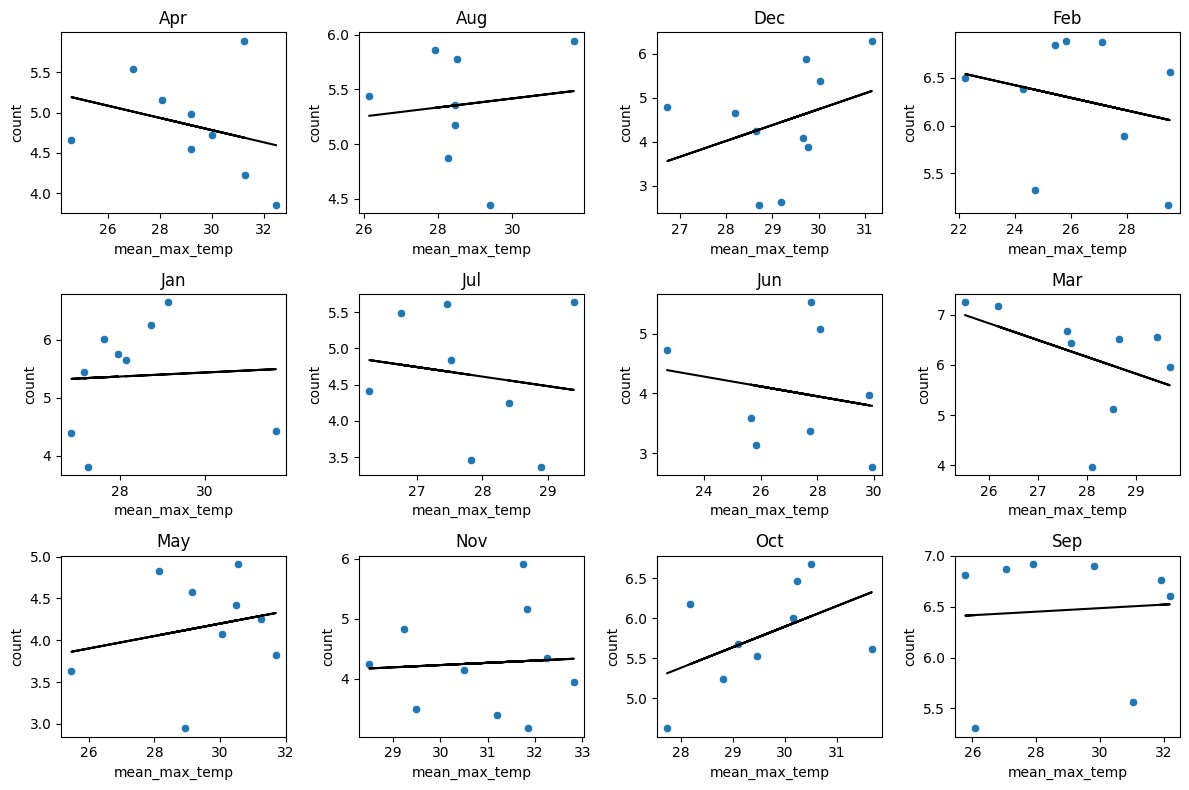

In [56]:
#after the rainfall, I added the max temp plot like noted
# IMPORTANT: I changed the mapping of the x-axis (line 1383) in R code to the correct column

 # Fire frequency vs maximum temperature by month (equivalent to R’s corplot2)
plt.figure(figsize=(12, 8))
for i, m in enumerate(sorted(fire_clim['month2'].unique())):
    ax = plt.subplot(3, 4, i + 1)
    sub = fire_clim[fire_clim['month2'] == m]

    # scatter points (R’s geom_point)
    sns.scatterplot(x='mean_max_temp',
                    y=np.log(sub['count']),
                    data=sub,
                    ax=ax)

    # regression line (R’s geom_smooth(method='lm'))
    slope, intercept, *_ = stats.linregress(
        sub['mean_max_temp'],
        np.log(sub['count'])
    )
    ax.plot(sub['mean_max_temp'],
            intercept + slope * sub['mean_max_temp'],
            color='black')

    ax.set_title(m)

plt.tight_layout()
plt.show()
# here marks the end of the addition of the max temp plot

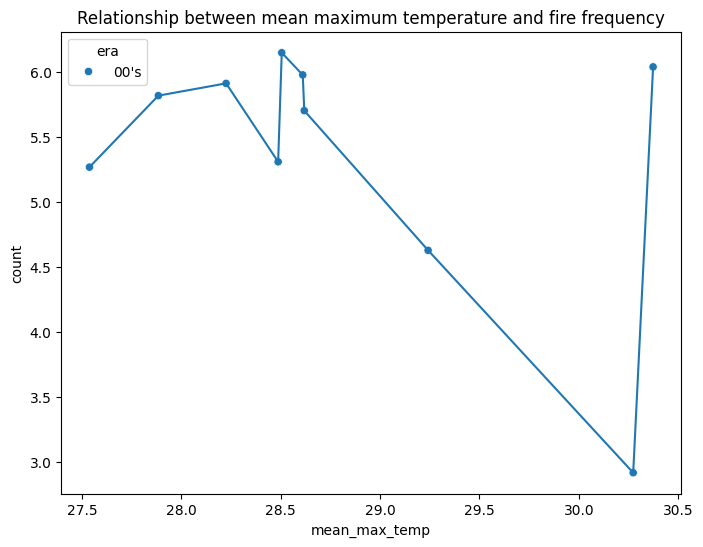

In [57]:
# --- 14. Era comparison ----------------------------------------------

# que: this needs to be done for rainfall as well lines 1434 to 1461 R code
# ans: will do it below
fire_clim['era'] = np.where(fire_clim['year'] < 2010, "00's", "10's")
avg = fire_clim.groupby(['year', 'era']).agg({'mean_max_temp': 'mean', 'count': 'mean'}).reset_index()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mean_max_temp', y=np.log(avg['count']), hue='era', data=avg)
sns.lineplot(x='mean_max_temp', y=np.log(avg['count']), hue='era', data=avg, legend=False)
plt.title('Relationship between mean maximum temperature and fire frequency')
plt.show()

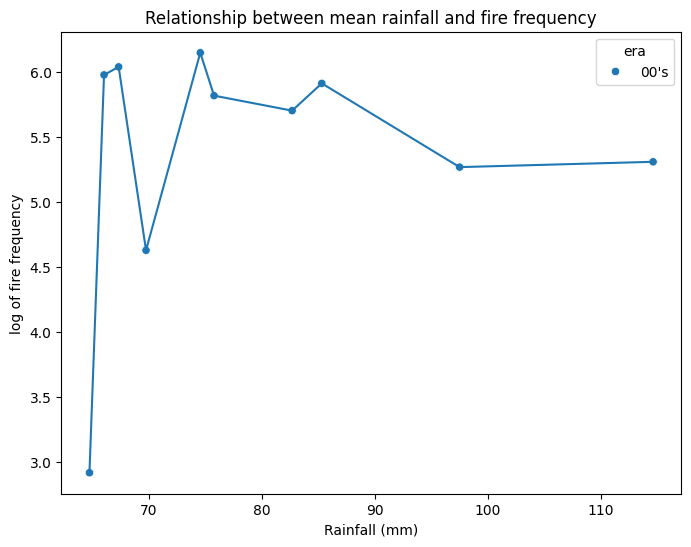

In [58]:
# I will add the mean raifall like stated above
# Relationship between mean rainfall and fire frequency (equivalent to R’s rain_fire_avg)
avg_rain = (
    fire_clim
    .groupby(['year', 'era'])
    .agg({'mean_rainfall': 'mean', 'count': 'mean'})
    .reset_index()
)

plt.figure(figsize=(8, 6))

# scatter points (geom_point)
sns.scatterplot(
    x='mean_rainfall',
    y=np.log(avg_rain['count']),
    hue='era',
    data=avg_rain
)

# regression line (geom_smooth(method='lm'))
sns.lineplot(
    x='mean_rainfall',
    y=np.log(avg_rain['count']),
    hue='era',
    data=avg_rain,
    legend=False
)

plt.title('Relationship between mean rainfall and fire frequency')
plt.xlabel('Rainfall (mm)')
plt.ylabel('log of fire frequency')

plt.show()

In [60]:
#  combine Bayesian results
# rbind(bnb_result80, bnb_result90, bnb_result95) %>% data.frame()
bnb_results = pd.concat([bnbt_result80, bnbt_result90, bnbt_result95], ignore_index=True)
print(bnb_results)

#  fit NB and Bayesian models on the same train/test split
n = len(series_data2['count'])                        # R: n = length(series_data2$count)
# The variable `prop` is not defined in this cell, it should be passed as an argument or defined before use.
# Assuming prop is intended to be 0.8 based on the previous cell's usage.
prop = 0.8
idx = round(prop * n)                                 # R: trainIndex <- round(prop*n)
fireTrain = series_data2.iloc[:idx]                   # R: fireTrain <- series_data2[1:trainIndex,]
fireTest  = series_data2.iloc[idx:]                   # R: fireTest  <- series_data2[(trainIndex+1):n,]

   rmse_train   rmse_test  mase_test   bias_test    n  prop
0  287.955777  366.656450   0.926668  -14.406890  106  0.80
1  305.379315  403.293261   0.885381   21.496512  106  0.90
2  314.522819  128.293414   2.027119  145.853659  106  0.95


In [61]:
train = fireTrain.copy()
train['sin'] = np.sin(((2*train['tyme']*np.pi)/12) + np.random.normal(scale=0.1)) # seasonality change 9
train['cos'] = np.cos(((2*train['tyme']*np.pi)/12) + np.random.normal(scale=0.1)) # seasonality change 10
X_nb = sm.add_constant(train[['mean_max_temp','mean_rainfall','sin','cos']])
y_nb = train['count']
glmNB = sm.GLM(y_nb, X_nb, family=sm.families.NegativeBinomial()).fit()

In [62]:
# R lines 444–451: NB prediction intervals via ciTools::add_pi
# Python: approximate using model.get_prediction().conf_int()
pred_nb = glmNB.get_prediction(sm.add_constant(
    fireTest[['mean_max_temp','mean_rainfall']].assign(
        sin=np.sin((2*fireTest['tyme']*np.pi)/12), # seasonality change 11
        cos=np.cos((2*fireTest['tyme']*np.pi)/12)  # seasonality change 12
    )
))
intervals_nb = pred_nb.conf_int(alpha=0.05)
nb_int_df = pd.DataFrame(intervals_nb, columns=['lower','upper'])
nb_int_df['count'] = fireTest['count'].values
nb_int_df['pred']  = np.round(pred_nb.predicted_mean).astype(int)
nb_int_df.to_csv('prediction_intervals2.csv', index=False)
print(nb_int_df)


         lower       upper  count  pred
0   209.996046  535.185649    541   335
1   225.412389  558.364817    768   355
2   280.194501  780.188274    938   468
3   189.306025  403.391148    786   276
4   106.186715  255.082387    113   165
5    86.664784  217.437434     83   137
6   170.352207  713.281208    112   349
7   134.571301  288.299502     70   197
8   187.481017  616.198448    231   340
9   130.623311  332.114225    867   208
10  161.349813  419.525055    275   260
11  287.854864  746.664698     70   464
12  350.923961  890.122456    120   559
13  255.403712  628.666688    283   401
14  293.145219  976.124468    594   535
15  219.606220  570.294372   1402   354
16  123.593315  271.672688    146   183
17   93.580323  223.064266     59   144
18  123.657542  281.927465    102   187
19  115.649137  256.696353     33   172
20  156.127854  399.417390     70   250


In [64]:
# R lines 453–464: BNB prediction intervals
# Python: placeholder for posterior predictive intervals
# intervals_bnb = your_bayesian_model.predictive_interval(fireTest, prob=0.95)
# prd2 = posterior_samples.mean(axis=0)
# build preds_bnb similarly, then:
# preds_bnb_df.to_csv('prediction_intervals_pap.csv')
# here instead of ('prediction_intervals_pap.csv') it will be saved to ('prediction_intervals2') check the code above
# R lines 466–472: review
pred_intBNB = pd.read_csv('/content/prediction_intervals2.csv')
print(pred_intBNB.head())

# R lines 474–494: combine NB & BNB data
nbdata  = nb_int_df[['count','lower','upper','pred']].copy()
nbdata['model'] = 'NB'

bnbdata = pred_intBNB[['count','lower','upper','pred']].copy()
bnbdata['model'] = 'BNB'

pidata = pd.concat([nbdata, bnbdata], ignore_index=True)

        lower       upper  count  pred
0  209.996046  535.185649    541   335
1  225.412389  558.364817    768   355
2  280.194501  780.188274    938   468
3  189.306025  403.391148    786   276
4  106.186715  255.082387    113   165


In [65]:
# Attach time index for the second half of your series (R used rows 175:218)
# here the error is because we don't have any row from (174:218)
# our dataset only has 106 rows, but it is obvious they had another bigger dataset.
timer = series_data2.iloc[174:218].copy()
timer['month_year2'] = pd.to_datetime(
    timer[['year','month']].assign(day=1)
)
pidata['Time'] = np.tile(timer['month_year2'].values, 2)

ValueError: Length of values (0) does not match length of index (42)

In [66]:
# R lines 496–510: build df for ribbon plots
df = pd.DataFrame({
    'x': np.arange(1, 45),
    'y': nbdata['count'],
    'modelNB_pred': nbdata['pred'],
    'modelNB_upper': nbdata['upper'],
    'modelNB_lower': nbdata['lower'],
    'modelBNB_pred': bnbdata['pred'],
    'modelBNB_upper': bnbdata['upper'],
    'modelBNB_lower': bnbdata['lower'],
})


ValueError: array length 44 does not match index length 21

In [67]:
# R lines 512–530: ggplot ribbon + lines
plt.figure(figsize=(10,5))
plt.plot(df['x'], df['y'], color='black', linewidth=1, label='Actual')
plt.fill_between(df['x'], df['modelNB_lower'], df['modelNB_upper'],
                 alpha=0.3, color='blue', label='NB Interval')
plt.plot(df['x'], df['modelNB_pred'], color='blue', linewidth=1, label='NB Pred')
plt.fill_between(df['x'], df['modelBNB_lower'], df['modelBNB_upper'],
                 alpha=0.3, color='red', label='BNB Interval')
plt.plot(df['x'], df['modelBNB_pred'], color='red', linewidth=1, label='BNB Pred')
plt.xlabel('Data Points')
plt.ylabel('Fire frequency')
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'x'

<Figure size 1000x500 with 0 Axes>

In [68]:
# R lines 532–540: combined time-series ribbon facet
plt.figure(figsize=(12,6))
sns.lineplot(data=pidata, x='Time', y='count', color='black', label='Actual')
sns.lineplot(data=pidata, x='Time', y='lower', hue='model', linestyle='--', alpha=0.5)
sns.lineplot(data=pidata, x='Time', y='upper', hue='model', linestyle='--', alpha=0.5)
sns.lineplot(data=pidata, x='Time', y='pred', hue='model', linewidth=1)
plt.title('Comparison of predictions and prediction intervals for the models')
plt.xlabel('Year of Observation')
plt.ylabel('Fire frequency')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `Time` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [69]:
# R lines 542–548: cor.test
print("BNB corr:", stats.pearsonr(bnbdata['count'], bnbdata['pred']))
print("NB corr: ", stats.pearsonr(nbdata['count'], nbdata['pred']))

# R lines 550–578: pivot_longer & patchwork
nb_long = nbdata.melt(id_vars=[], value_vars=['lower','pred','upper'],
                      var_name='interval', value_name='count').assign(
    index=lambda df: np.repeat(np.arange(1,45),3)
)
plt.figure(figsize=(10,4))
sns.lineplot(data=nb_long, x='index', y='count', hue='interval')
plt.title('Prediction intervals of the NB model')
plt.tight_layout()
plt.show()

bnb_long = bnbdata.melt(id_vars=[], value_vars=['lower','pred','upper'],
                        var_name='interval', value_name='count').assign(
    index=lambda df: np.repeat(np.arange(1,45),3)
)
plt.figure(figsize=(10,4))
sns.lineplot(data=bnb_long, x='index', y='count', hue='interval')
plt.title('Prediction intervals of the BNB model')
plt.tight_layout()
plt.show()

BNB corr: PearsonRResult(statistic=np.float64(0.31609520118447704), pvalue=np.float64(0.162735893586977))
NB corr:  PearsonRResult(statistic=np.float64(0.31609520118447704), pvalue=np.float64(0.162735893586977))


ValueError: value_name (count) cannot match an element in the DataFrame columns.

NameError: name 'nb_long' is not defined

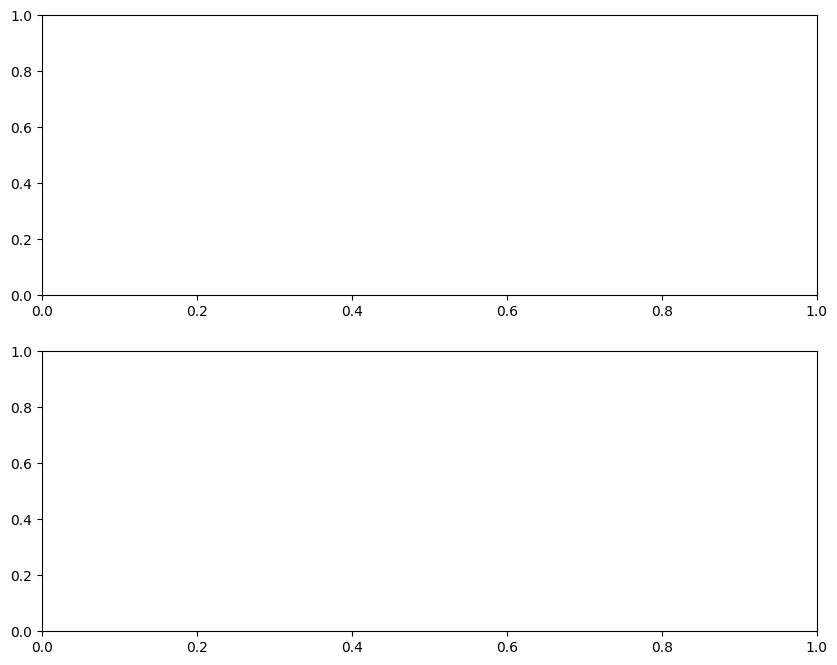

In [70]:
# To “stack” them (patchwork), use subplots:
fig, axes = plt.subplots(2,1, figsize=(10,8))
sns.lineplot(data=nb_long, x='index', y='count', hue='interval', ax=axes[0]).set_title('NB')
sns.lineplot(data=bnb_long, x='index', y='count', hue='interval', ax=axes[1]).set_title('BNB')
plt.tight_layout()
plt.show()